# Model Comparison

In [24]:
import pandas
# from Myelotoxicity_pkpd.PK_model import PintsLinCompIV
from Myelotoxicity_pkpd.Likelihoods import MultiplicativeGaussianLogLikelihood, GaussianLogLikelihood, ConstantAndMultiplicativeGaussianLogLikelihood
from Myelotoxicity_pkpd.PD_model import PintsPDFriberg
import pints
# import pints.plot
import pints.io
import numpy as np
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
import arviz as az
import scipy

In [5]:
drug = 'Docetaxel'
dose = 10.0
num_comp = 2
observation_name = 'Platelets '

## WAIC & PSIS-LOO

### Simulated Data

In [8]:
# PD_actual_params = np.load("Data_and_parameters/pd_sim_actual_params_dose_2.npy")
# PD_param_names = ["Circ_0", "MTT", "gamma", "slope", "sigma_base", "eta", "sigma_rel"]
# print("Parameters used for simulated data:")
# for i in range(0,len(PD_param_names)):
#     print(PD_param_names[i] + " = " + str(PD_actual_params[i]))

df = pandas.read_csv("./Data_and_parameters/pd_sim_data_dose_2")
observed = az.convert_to_inference_data(np.asarray(df['OBS']), group='observed_data')

In [19]:
model_types = ["add", "mult_noeta", "comb_noeta"]
compare_dict = {}
data_type = 'real'

for model_type in model_types:
    
    samples = np.asarray(pints.io.load_samples('Data_and_parameters/PD_sim/MCMC_'+model_type+'_samples_chain', n=3))
    pointwise = np.asarray(pints.io.load_samples('Data_and_parameters/PD_sim/MCMC_'+model_type+'_pointloglike_chain', n=3))
    likelihood = az.convert_to_inference_data(pointwise, group='log_likelihood')
    posterior = az.convert_to_inference_data(samples, group='posterior')
    
#     print('----------------------------------------------------------------------------------')
#     print(model_type)
#     print('----------------------------------------------------------------------------------')
#     print(pints.MCMCSummary(samples))
#     print('\n')
    
    inference_data = az.concat(likelihood, posterior, observed)
    compare_dict[model_type] = inference_data


In [27]:
comparison = az.compare(compare_dict)
comparison

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/rumney/Docum

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
add,0,-955.630979,831.728873,0.000000,0.211743,183.350858,0.000000,True,log
comb_noeta,1,-1636.394557,1515.850686,680.763579,0.722973,676.389329,540.385894,True,log
mult_noeta,2,-4826.614530,4706.788425,3870.983551,0.065284,1974.371126,1894.607906,True,log


In [29]:
model_type = "mult_noeta"
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = "comb_noeta"
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)


mult_noeta
	 z value = 2.043158131982357
	 p value = 0.020518393420111587
comb_noeta
	 z value = 1.2597730366684867
	 p value = 0.10387562461516808


In [21]:
comparison = az.compare(compare_dict, ic="waic")
comparison

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
comb_noeta,0,-333.735949,213.192078,0.000000,9.016358e-01,72.365357,0.000000,True,log
mult_noeta,1,-1001.577303,881.751198,667.841354,9.028581e-12,270.762385,208.213554,True,log
add,2,-1591.217913,1467.315808,1257.481964,9.836425e-02,656.952722,590.558038,True,log


In [26]:
model_type = "mult_noeta"
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = "add"
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)


mult_noeta
	 z value = 3.2074826055742145
	 p value = 0.0006695107890988216
add
	 z value = 2.1293114046419968
	 p value = 0.016614252430094092


### Pharmaceutical Data

In [39]:
df = pandas.read_csv("./Data_and_parameters/PD_real/pd_real_data_refined_" + drug+ "_dose_" + str(dose))
observed = az.convert_to_inference_data(np.asarray(df['OBS']), group='observed_data')

In [46]:
model_types = {"add": "Constant noise", "mult_noeta" : "Relative noise", "comb_noeta" : "Combined noise"}
compare_dict = {}
data_type = 'real'

for model_type in model_types:
    
    samples = np.asarray(pints.io.load_samples(
        'Data_and_parameters/PD_real/MCMC_'+model_type+'_samples_dose_'+str(dose)+'_chain', 
        n=3
    ))
    pointwise = np.asarray(pints.io.load_samples(
        'Data_and_parameters/PD_real/MCMC_'+model_type+'_pointloglike_dose_'+str(dose)+'_chain', 
        n=3
    ))
    likelihood = az.convert_to_inference_data(pointwise, group='log_likelihood')
    posterior = az.convert_to_inference_data(samples, group='posterior')
    
#     print('----------------------------------------------------------------------------------')
#     print(model_type)
#     print('----------------------------------------------------------------------------------')
#     print(pints.MCMCSummary(samples))
#     print('\n')
    
    inference_data = az.concat(likelihood, posterior, observed)
    compare_dict[model_types[model_type]] = inference_data


In [47]:
comparison = az.compare(compare_dict)
comparison

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/rumney/Docum

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Combined noise,0,-173.164998,44.983376,0.000000,1.661112e-01,15.354781,0.000000,True,log
Relative noise,1,-180.504781,51.794150,7.339783,8.338888e-01,29.020542,30.681383,True,log
Constant noise,2,-711.488750,571.966213,538.323753,1.221245e-14,113.107509,98.560549,True,log


In [42]:
model_type = "mult_noeta"
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = "add"
z_value = comparison["d_loo"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)


mult_noeta
	 z value = 0.2392259696383931
	 p value = 0.40546518317034047
add
	 z value = 5.4618583089823725
	 p value = 2.3558804539665205e-08


In [43]:
comparison = az.compare(compare_dict, ic="waic")
comparison

/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/rumney/Documents/Myleotoxicity/Myleotoxicity-PKPD/venv/lib/python3.

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
mult_noeta,0,-183.805715,55.095083,0.000000,0.991777,20.343813,0.000000,True,log
comb_noeta,1,-259.931779,131.750157,76.126064,0.008223,51.709643,32.576889,True,log
add,2,-2563.864058,2424.341521,2380.058343,0.000000,805.427946,785.474949,True,log


In [44]:
model_type = "comb_noeta"
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)

model_type = "add"
z_value = comparison["d_waic"][model_type] / comparison["dse"][model_type]
p_value = scipy.stats.norm.sf(abs(z_value))
print(model_type)
print("\t z value =", z_value)
print("\t p value =", p_value)


comb_noeta
	 z value = 2.3368119852323805
	 p value = 0.009724481184465795
add
	 z value = 3.030088159375842
	 p value = 0.00122241182077949


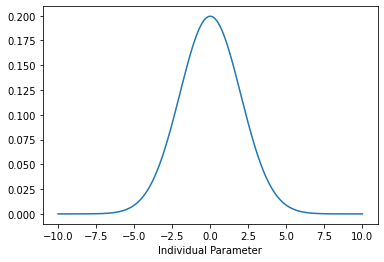

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-10, 10, 0.001)
# Mean = 0, SD = 2.
plt.plot(x_axis, norm.pdf(x_axis,0,2))
plt.xlabel("Individual Parameter")

plt.savefig("normal_dist_ind.svg")
plt.show()